# 3　統計的実験計画におけるベイズ最適化

**課題**　ある材質は、硬度と粘度の2つの値から劣化促進度が決まることが知られています。そこで、ある会社はなるべく劣化促進度の低い材質を作るための硬度と粘度を効率的に探索したいと考えています。なお、事前実験によって5つの（硬度、粘度）の組については、その劣化促進度をデータとして持っているものとします。

以下では、この課題に対してベイズ最適化によるアプローチを検討します。

In [2]:
import sys
sys.path.append("/Users/gonakazawa/.pyenv/versions/3.10.6/lib/python3.10/site-packages")

In [6]:
!pip install matplotlib
!pip install GPy
!pip install GPyOpt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  DEPRECATION: GPyOpt is being installed using the legacy 'setup.py install' method, because it does not have a 'pyproject.toml' and the 'wheel' package is not installed. pip 23.1 will enforce this behaviour change. A possible replacement is to enable the '--use-pep517' option. Discussion can be found at https://github.com/pypa/pip/issues/8559
  Running setup.py install for GPyOpt ... done


In [7]:
# import文
import numpy as np
import pandas as pd

import GPy
import GPyOpt
from GPyOpt.methods import BayesianOptimization

## 3.1　事前実験

In [8]:
data = pd.read_csv("./data/pre_experiment.csv")
data.head(n = 5)

,x1,x2,y
0,-3.0,-2.0,162.900
1,-2.4,-2.0,69.868
2,-1.8,-2.0,53.852
3,-1.2,-2.0,52.801
4,-0.6,-2.0,50.383


In [9]:
# GPyOptにわたすために、入力Xと出力yをどちらも2次元配列で準備する。
# sklearnは出力が1次元なので、準備の仕方が異なることに注意。
X, Y = data[["x1", "x2"]].values, data[["y"]].values

## 3.2　諸設定

探索範囲を指定する。今回は、硬度(x1)は-3<x1<3で、粘度(x2)は-2<x2<2で探索する。

In [10]:
domain = [{"name" : "x1", "type" : "continuous", "domain" : (-3, 3)},
          {"name" : "x2", "type" : "continuous", "domain" : (-2, 2)}]    # boundsと名付ける人もいます。

In [11]:
kernel = GPy.kern.Matern52(input_dim = 2)

## 3.3　ガウス過程回帰モデルの学習

実際の実験に`BayesianOptimization`クラスを援用するには、関数`f`を実験後に外部から入力できるように実装する必要があります。それが以下のスクリプトです。

In [12]:
# 外部からの出力yの観測値の入力フォームを実装する。
try_ = 1

def f(x):    # x : BayesOptimizationクラスから次の実験候補が渡される場所。
    global try_    # globalスコープ : 関数fの外で定義されたtry_を使っていきます。

    print("Try : " , try_ , "next x is ", x)
    #score = float(input("Input y : "))    # 入力フォーム
    y = float(input("Input y : "))
    score = (y - 5)**2

    try_ += 1

    return score

In [14]:
opt = BayesianOptimization(f = None,    # new1 : ここは未知。実装が変わります。上記。
                           domain = domain,
                           X = X,    # new2 : 事前実験の結果はX, Yに指定します。X:入力, Y:出力。
                           Y = Y,    # new2
                           normalize_Y = False, #関数値を出力するときに正規化するか？
                           initial_design_numdata = 0,    # new2
                           kernel = kernel,
                           aquisition_type = "EI", 
                           exact_feval = False)    # Falseで出力yの観測値にノイズがのっている前提になります。

## 3.4　次の探索候補の提案と最適解の求解

以下のスクリプトは、

1. 事前に与えられたデータで関数のモデルを推定
2. 得られた関数モデルから次の実験候補を1つ提案
3. 私達が、その実験の結果を入力
4. 関数モデルを更新

という4つのステップを行います。

In [15]:
opt.run_optimization(max_iter = 3)

InvalidConfigError: Cannot run the optimization loop without the objective function

In [9]:
opt.x_opt, opt.fx_opt

(array([ 0.0211697 , -0.54210991]), -0.9346822)

## 3.5　収束の確認

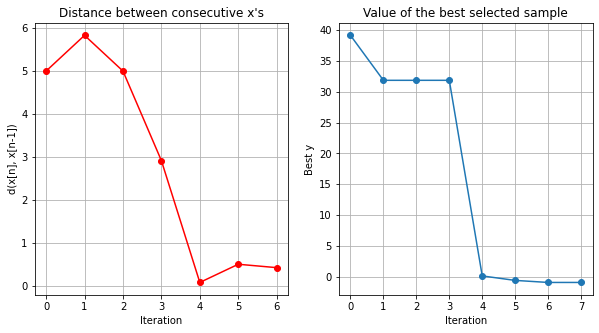

In [10]:
opt.plot_convergence()

In [26]:
from sklearn.metrics import r2_score
r2_score(opt.model.predict(opt.X)[0].reshape(-1), opt.Y.reshape(-1))

-607.0206426626003

事後分布の標準偏差を確認することで、どの（硬度、粘度）の値に対して、私達がまだ十分に実験できていないかを確認することができます。

In [ ]:
opt.plot_acquisition()

In [ ]:
opt.suggest_next_locations()